借助 Intel(R) Extension for Scikit-learn，您可以加速您的 Scikit-learn 应用程序，并且仍然完全符合所有 Scikit-Learn API 和算法。这是一款免费软件 AI 加速器，可为各种应用带来超过10-100 倍的加速。而且您甚至不需要更改现有代码！

In [487]:

   ## !python -m pip install pandas matplotlib scikit-learn-intelex scikit-learn openpyxl tensorboard seaborn ipykernel ipywidgets tensorflow mypy keras
 #tensorflow[and-cuda]

    

In [488]:
# 本导入顺序可以看到类型
import tensorflow as tf
# import tensorflow_datasets as tfds
import datetime
import os
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# from tensorflow import keras
import keras as keras
 
from keras import layers
from keras import models

from keras import backend as K

# K =keras.backend

patch_sklearn() 
# from attention_utils import get_activations

#更好地兼容 Python 3 的行为和特性，使得代码可以在 Python 2 和 Python 3 下运行得更加一致
# from __future__ import absolute_import,division,print_function,unicode_literals

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [489]:
import tensorflow as tf
import datetime
print(' ')
print(f'{datetime.datetime.now()} tensorflow版本:', tf.__version__)
gpus = tf.config.experimental.list_physical_devices("GPU")
print(' ')
print('gpus： ')
print(gpus)
print(' ')
print('gpus')
# 查看系统中可见的GPU设备
print("Available GPU devices:", tf.config.list_physical_devices("GPU"))

 
2024-03-20 14:53:12.036813 tensorflow版本: 2.16.1
 
gpus： 
[]
 
gpus
Available GPU devices: []


In [490]:
refeshdata = False

categories = ["-", "装", "卸"]


def convert_to_int(data):
    return categories.index(data)


# 确保'label'列是一个分类类型（如果还不是的话）
# if not isinstance(df_selected["label"].dtype, pd.CategoricalDtype):
#     df_selected["label"] = df_selected["label"].astype("category")

if refeshdata or 'dfstate' not in locals() or (hasattr(
        locals()['dfstate'], 'empty') and locals()['dfstate'].empty):
    dfstate = pd.read_csv("./data/states.txt")
    dfstate["start"] = dfstate.apply(
        lambda row: row["date"] + " " + row["start_time"], axis=1)
    dfstate["end"] = dfstate.apply(
        lambda row: row["date"] + " " + row["end_time"], axis=1)
    dfstate["label"] = dfstate.pop("state").str.strip().apply(convert_to_int)
    
    # 转为时间类型
    dfstate[["start", "end"]] = dfstate[["start", "end"]].apply(pd.to_datetime)
    # dfstate["statev"] = dfstate.apply(label_to_number, axis=1)
    # dfstate['label'] = dfstate.apply(number_to_label,axis=1)
    dfstate.to_csv("./data/states.csv")
    # print(dfstate.head(), dfstate.shape)

dfstate.head()

,date,start_time,end_time,start,end,label
0,2023-12-17,10:44:49,10:48:59,2023-12-17 10:44:49,2023-12-17 10:48:59,1
1,2023-12-17,11:29:45,11:31:55,2023-12-17 11:29:45,2023-12-17 11:31:55,2
2,2023-12-17,12:23:56,12:29:44,2023-12-17 12:23:56,2023-12-17 12:29:44,1
3,2023-12-17,12:55:08,12:56:28,2023-12-17 12:55:08,2023-12-17 12:56:28,2
4,2023-12-17,13:45:02,13:45:42,2023-12-17 13:45:02,2023-12-17 13:45:42,1


In [491]:
dfstate.head()

,date,start_time,end_time,start,end,label
0,2023-12-17,10:44:49,10:48:59,2023-12-17 10:44:49,2023-12-17 10:48:59,1
1,2023-12-17,11:29:45,11:31:55,2023-12-17 11:29:45,2023-12-17 11:31:55,2
2,2023-12-17,12:23:56,12:29:44,2023-12-17 12:23:56,2023-12-17 12:29:44,1
3,2023-12-17,12:55:08,12:56:28,2023-12-17 12:55:08,2023-12-17 12:56:28,2
4,2023-12-17,13:45:02,13:45:42,2023-12-17 13:45:02,2023-12-17 13:45:42,1


In [492]:
# 定义读取数据函数
def fix_data(inputDF: pd.DataFrame) -> pd.DataFrame:
    # 创建一个新的空列用于存储结果
    inputDF.insert(0, "before", False)
    inputDF.insert(0, "after", False)
    inputDF.insert(0, "label", 0)
    # 对df1中的每一行遍历，并查找df2中符合条件的记录
    for index, row in inputDF.iterrows():
        
        
        condition = (dfstate["start"] <= row["时间"]) & (row["时间"] <= dfstate["end"])
        match = dfstate[condition]
        if not match.empty:
            # 如果找到了匹配项，则将df2的'state'赋值给df1的新列
            inputDF.at[index, "label"] = match["label"].values[0]
        else:
            # 如果没有找到匹配项，则保持原样（这里已经初始化为-）
            pass
        
    # inputDF.insert(1,'state',0)
    # inputDF["state"] = inputDF["label"].astype("category").cat.codes
    return inputDF
def read_data(file_path: str) -> pd.DataFrame:
    return fix_data(
        pd.read_excel(file_path, engine="openpyxl", parse_dates=["时间", "轨迹时间"])
    )


# 读取数据
if refeshdata or 'odf17' not in locals() or (hasattr(locals()['odf17'], 'empty') and locals()['odf17'].empty):
    # 如果df未定义或为空DataFrame
    odf17 = read_data("./data/data_17.xlsx")
    odf21 = read_data("./data/data_21.xlsx")
    odf22 = read_data("./data/data_22.xlsx")
    odf23 = read_data("./data/data_23.xlsx")


组合数据集

In [493]:
numeric_col_names = ['原始重量', '稳定重量', '轴重', 'su_ad',
                     'wpu_x', 'wpu_y', 'wpu_z',
                     'su_x', 'su_y', 'su_z']
# delete some
#  "轨迹时间",'原始重量_diff', '稳定重量_diff', '轴重_diff','su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff','估计重量',    'su_x_diff','su_y_diff', 'su_z_diff',  ,
# ['原始重量', '稳定重量', '轴重', 'su_ad',
#                 'wpu_x', 'wpu_y', 'wpu_z',
#                 'su_x', 'su_y', 'su_z',
#                 '原始重量_diff', '稳定重量_diff', '轴重_diff',
#                 'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff',
#                 'su_x_diff', 'su_y_diff', 'su_z_diff',
#                 '速度', '估计重量', '原始重量加速度', '稳定重量加速度', '原始重量加速度_二阶', '稳定重量加速度_二阶']
label_col_names = ["label"]
time_col_names = ["时间"]
feature_col_names = numeric_col_names  # 暂时去掉 时间
feature_col_num = len(feature_col_names)

class_num = len(categories)
# print(class_num)
time_steps = 6

INPUT_DIMS_COlUMNS = feature_col_num


all_col_names = numeric_col_names + label_col_names + time_col_names
df17, df21, df22, df23 = odf17[all_col_names], odf21[all_col_names], odf22[all_col_names], odf23[all_col_names]
_origindata = pd.concat([df17, df21, df22], axis=0, ignore_index=True)

print(_origindata.columns)
print(_origindata.shape)
display(df17.shape, df22.shape, df23.shape, df23.shape)

_origindata.head()

Index(['原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z', 'su_x',
       'su_y', 'su_z', 'label', '时间'],
      dtype='object')
(69407, 12)


(16530, 12)

(27913, 12)

(27942, 12)

(27942, 12)

,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,su_y,su_z,label,时间
0,-4063,2020,-4375,33161,13662,326,76328,1867,-1010,87720,0,2023-12-17 09:39:23
1,-4175,2020,-4364,33160,13636,327,76355,1867,-1010,87720,0,2023-12-17 09:39:26
2,-4575,2020,-4486,33171,13649,312,76342,1867,-1005,87725,0,2023-12-17 09:39:30
3,-4330,2020,-4397,33163,13649,314,76342,1867,-999,87731,0,2023-12-17 09:39:32
4,-4442,2020,-4475,33170,13648,314,76343,1873,-1005,87720,0,2023-12-17 09:39:35


筛选数据，

In [494]:
def expandRows(idx_list_list, windowsize=20) -> np.ndarray:
    my_array = np.arange(-windowsize, windowsize + 1)
    new_array = idx_list_list.copy()
    for item in my_array:
        new_array += [element + item for element in indices_list]
    ret = np.sort(list(dict.fromkeys(new_array)))

    return ret


indices_list = _origindata.index[_origindata['label'] > 0].tolist(
)  # + _origindata.index[_origindata['label'] == '卸'].tolist()
indices_list = expandRows(indices_list)

# 或者使用.iloc基于位置索引（如果是整数索引）
df_selected = _origindata.iloc[indices_list]

df_selected.head()

,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,su_y,su_z,label,时间
1231,-9307,0,-9786,33647,12697,-4264,76550,2988,3218,85407,0,2023-12-17 10:43:45
1232,-10766,0,-10654,33725,12739,-4197,76551,2971,3070,85561,0,2023-12-17 10:43:47
1233,-10654,0,-10677,33727,12724,-4167,76583,2966,3037,85605,0,2023-12-17 10:43:51
1234,-10632,0,-9753,33644,12715,-3882,76678,2955,2823,85753,0,2023-12-17 10:43:54
1235,-16595,0,-17179,34311,13123,-4439,76090,2642,2741,85995,0,2023-12-17 10:43:57


c:\ScriptsApplications\.devhome\conda\envs\py311tf2.16\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ScriptsApplications\.devhome\conda\envs\py311tf2.16\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ScriptsApplications\.devhome\conda\envs\py311tf2.16\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ScriptsApplications\.devhome\conda\envs\py311tf2.16\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ScriptsApplications\.devhome\conda\envs\py311tf2.16\Lib\site-packages

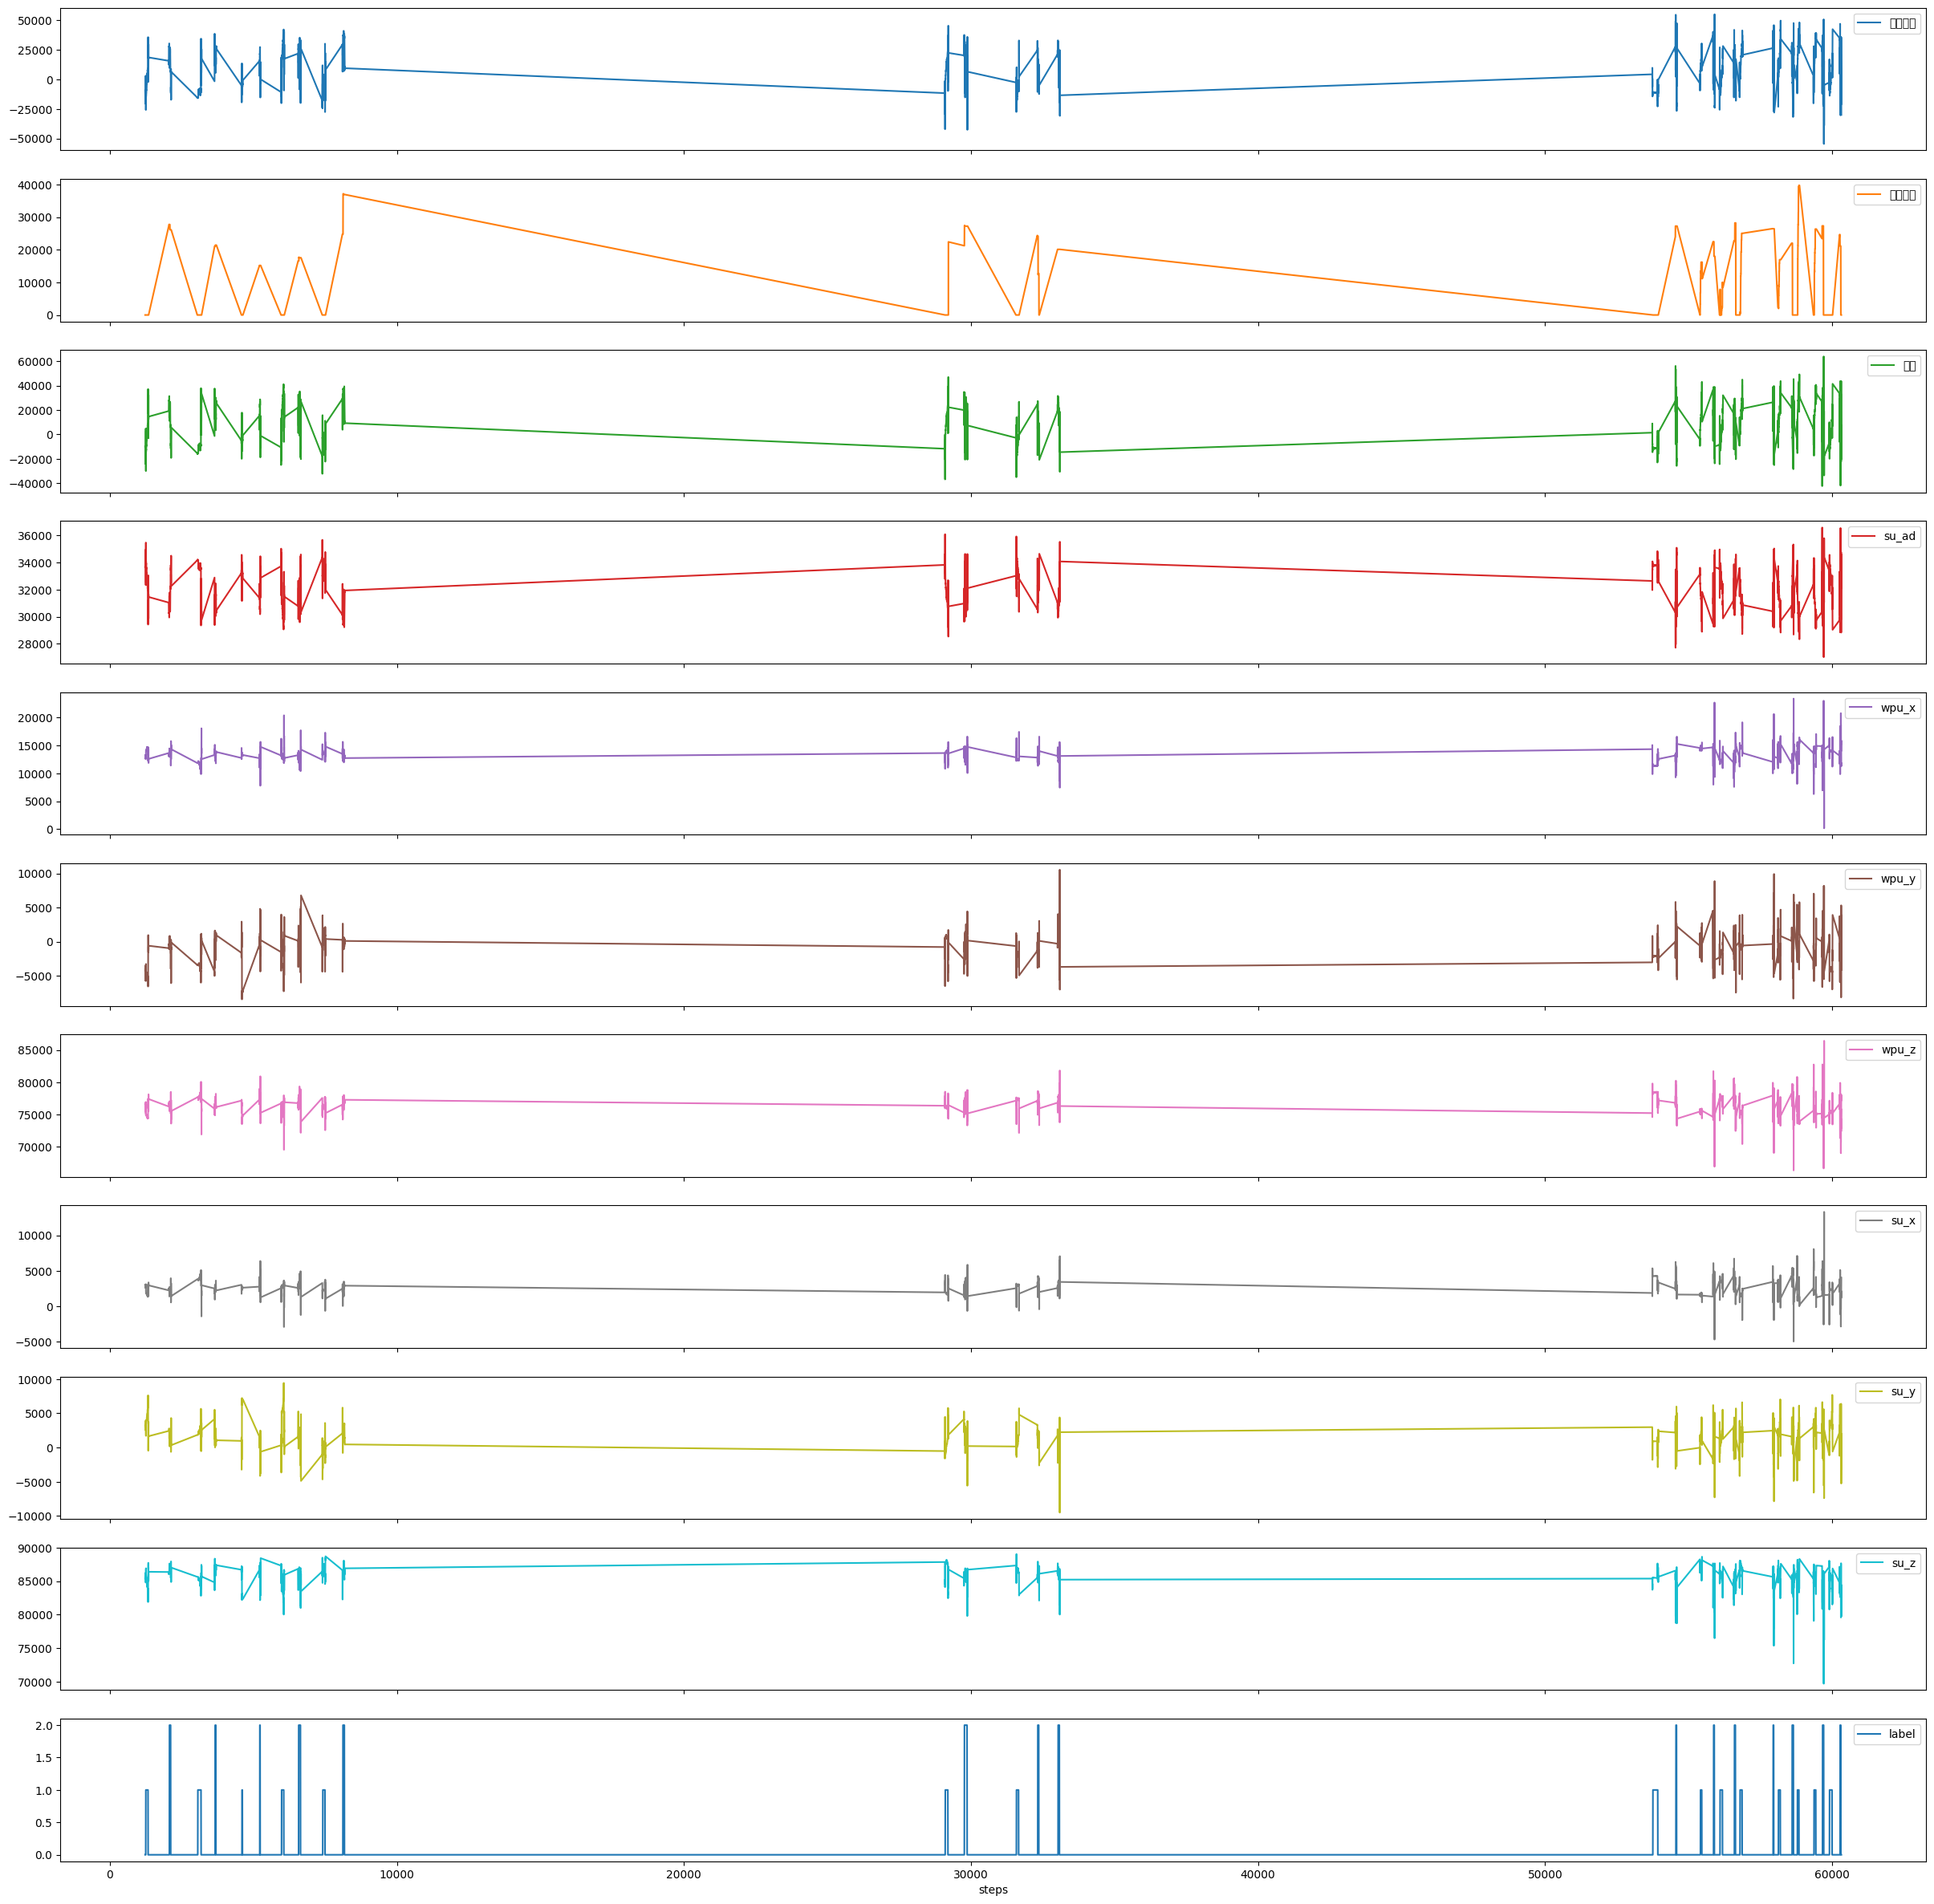

In [495]:
df_selected[feature_col_names + label_col_names].plot(legend=True,
                                                      subplots=True,
                                                      figsize=(30, 30),
                                                      xlabel="steps")
ax = plt.gca()
# ax.set_xlim(left=0, right=7600)
# 或者直接指定字体文件路径
# plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # 系统自带的黑体
# plt.rcParams['font.serif'] = ['DejaVu Sans']  # 系统自带的宋体
# plt.rcParams['font.family'] = ['DejaVu Sans']
plt.show()


### 归一化函数

In [496]:
from sklearn.preprocessing import OneHotEncoder


def normalize(
    inpudf: pd.DataFrame,
    numeric_col_names: list[str]
) -> np.ndarray: 
    # 使用 StandardScaler 或者 MinMaxScaler 进行标准化处理。
    # 创建标准化器对象
    scaler = MinMaxScaler()
    return   scaler.fit_transform(inpudf)
    # for col in numeric_col_names :        
    #     result[col]=scaler.fit_transform(np.asarray(inpudf[col] ))
 

# def normalizeY(y: pd.DataFrame):
#     """对df中的数值列进行反标准化处理"""
#     # 定义一个字典，将标签映射到整数值
#     custom_label_dict = {    '-': 0, '卸': 1, '装': 2, }
#     le = OneHotEncoder(categories='auto', sparse=False)
#     print('mapping ---->',custom_label_dict)
#     # 现在我们可以将ydata转换为数值
#     ydata_numeric = y.apply(lambda x: custom_label_dict[x['label']],axis=1)
#     return ydata_numeric
def normalizeY(y: pd.DataFrame):
    """对df中的数值列进行反标准化处理"""
    # 定义一个字典，将标签映射到整数值
    ydata =np.asarray(y[label_col_names])
    le = OneHotEncoder()
    le.fit(ydata) 

    return le.transform(ydata),le


In [497]:
# class weights


from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series:np.ndarray, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    # class_count = [0] * n_classes
    # for classes in class_series:
    #     for index in range(n_classes):
    #         if classes[index] != 0:
    #             class_count[index] += 1
    
    class_count = np.array(class_series).sum(axis=0)
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

## feature归一化

## label归一化

In [498]:

 


# le = OneHotEncoder()
# yTrain = le.fit_transform(df_selected_label)
print(df_selected["label"].dtype)
# if not isinstance(df_selected["label"].dtype, pd.Float32Dtype):
    # df_selected["label"] = df_selected["label"].astype(pd.)
# df_selected["label"] = tf.one_hot(df_selected["label"], depth=class_num)


df_selected.head()

int64


,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,su_y,su_z,label,时间
1231,-9307,0,-9786,33647,12697,-4264,76550,2988,3218,85407,0,2023-12-17 10:43:45
1232,-10766,0,-10654,33725,12739,-4197,76551,2971,3070,85561,0,2023-12-17 10:43:47
1233,-10654,0,-10677,33727,12724,-4167,76583,2966,3037,85605,0,2023-12-17 10:43:51
1234,-10632,0,-9753,33644,12715,-3882,76678,2955,2823,85753,0,2023-12-17 10:43:54
1235,-16595,0,-17179,34311,13123,-4439,76090,2642,2741,85995,0,2023-12-17 10:43:57


In [499]:
# target = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))

# for features in target.take(1):
#    # image, label = features["image"], features["label"]
#     # print(type(image))
#     print(type(features))

# for window in target.window(time_steps).take(5):

#     print(window)

# （Embedding）的一些关键点

Embedding是一种在深度学习中常用的技术，它将输入数据（如单词、图像、句子等）映射到低维度的向量空间中。这种映射使得原始数据可以被模型更好地处理和理解。在自然语言处理（NLP）中，嵌入通常用于将单词或字符转换为固定大小的向量，这些向量可以捕捉词汇的语义和上下文信息

1.  **维度 reduction**: 嵌入将高维数据（如词汇表中的单词）映射到低维空间，使得模型可以更容易地处理。
    
2.  **固定大小**: 嵌入向量通常是固定大小的，这使得它们可以被矩阵操作，便于模型处理。
    
3.  **非线性**: 嵌入通常是通过对输入数据进行非线性变换来生成的，这有助于模型捕捉复杂的关系。
    
4.  **预训练和微调**: 在NLP中，单词嵌入通常预先训练然后在特定任务上微调。预训练可以捕获通用语义信息，而微调可以捕捉任务特定的信息。
    
5.  **神经网络**: 嵌入经常与神经网络一起使用，特别是卷积神经网络（CNN）和循环神经网络（RNN），以处理复杂的输入数据。
    
6.  **应用**: 除了NLP，嵌入技术还广泛应用于计算机视觉（如图像嵌入）、音频处理和其他领域。


## 模型创建

In [500]:
from os import name

SINGLE_ATTENTION_VECTOR = False


def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    # a = Permute((2, 1))(inputs)
    # a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = layers.Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = layers.Lambda(lambda x: tf.reduce_mean(x, axis=1),
                          name='dim_reduction')(a)
        a = layers.RepeatVector(input_dim)(a)

    a_probs = layers.Permute((1, 2), name='attention_vec')(a)  # 维数转置

    output_attention_mul = layers.concatenate([inputs, a_probs],
                                              axis=-1)  # 把两个矩阵拼接
    return output_attention_mul


def attention_model(time_steps, input_dims, lstm_units,
                    output_dim) -> keras.Model:
    inputs = layers.Input(shape=(input_dims, ), name='input')
    x = layers.Dense(units=64, name='dense1')(inputs)
    # x = layers.Conv1D(filters=64, kernel_size=1,
    #                   activation='relu')(inputs)  # , padding = 'same'
    # x = layers.MaxPool1D(pool_size=2)(x)
    # x = layers.Dropout(0.3)(x)

    # lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    # 对于GPU可以使用CuDNNLSTM
    # x = layers.Bidirectional(
    #     layers.LSTM(lstm_units, return_sequences=False, name='lstm1'))(x)
    # x = layers.Dropout(0.3, name='dorpot1')(x)
    # x = attention_3d_block(x)

    # x = layers.Flatten()(x)
    # attention_mul = layers.Embedding(input_dims, output_dim)(attention_mul)
    output = layers.Dense(output_dim, activation='softmax', name='output_')(x)
    model = keras.Model(inputs=[inputs], outputs=output)
    return model

## 编译模型

In [501]:
drop = 0.2

# 调整学习率
optimizer = keras.optimizers.Adam(learning_rate=0.2)  # 学习率设置为0.001

# class_num=1
lstm_units = 64

model = attention_model(time_steps, INPUT_DIMS_COlUMNS, lstm_units, class_num)
# cce = keras.losses.CategoricalCrossentropy()
model.compile(
    optimizer='adam',
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
    #   steps_per_execution=5
)

# iputlayer = model.input
# print(xInput.shape,'===',iputlayer.shape)

# print(xInput.dtype,'===',iputlayer.dtype)

# print('----------')
# oputlayer = model.output
# print(yInput.shape,'===',oputlayer.shape)
# print(yInput.dtype ,'===',oputlayer.dtype)
# print(yInput.dtype ,'===',oputlayer.dtype)
# print(tf.sparse.

model.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_ (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 899 (3.51 KB)

 Trainable params: 899 (3.51 KB)

 Non-trainable params: 0 (0.00 B)

## 训练

In [506]:
def windowed_dataset(dataset: tf.data.Dataset,
                     window_size=5,
                     shift=1,
                     stride=1):
    windows = dataset.window(window_size,
                             shift=shift,
                             stride=stride,
                             drop_remainder=True)

    def sub_to_batch(t1, t2=None):
        t1_batches = t1.batch(window_size, drop_remainder=True)

        if t2 is not None:
            t2_batches = t2.batch(window_size, drop_remainder=True)
            return tf.data.Dataset.zip(t1_batches, t2_batches)
        else:
            return t1_batches

    windows = windows.flat_map(sub_to_batch)
    return windows


# batch_size = 20
batch_size = 6
epochs = 50


def one_hot_encoding(label):
    return tf.one_hot(label, depth=class_num)

# label_encoded = df_selected[label_col_names].apply(one_hot_encoding)

x = tf.data.Dataset.from_tensor_slices(df_selected[feature_col_names])

# featureTarget = windowed_dataset(x, time_steps)
featureTarget=x

y = tf.data.Dataset.from_tensor_slices(
    df_selected[label_col_names]).map(one_hot_encoding)

target = tf.data.Dataset.zip(featureTarget, y)

total_examples = len(x)  # 获取数据集总样本数
train_ratio = 0.6  # 训练集占比
num_train_examples = int(total_examples * train_ratio)
num_val_examples = total_examples - num_train_examples
train_dataset = target.take(num_train_examples)
val_dataset = target.skip(num_train_examples).take(num_val_examples)

trainWindow = train_dataset.batch(batch_size=batch_size)
valWindow = val_dataset.batch(batch_size=batch_size)

for x,y in train_dataset.take(14):
    print('x=======================')
    print(x.numpy())
    print('y---------------------')
    print(y.numpy())

AttributeError: in user code:

    File "C:\Users\tangj15\AppData\Local\Temp\1\ipykernel_10924\3820410410.py", line 29, in one_hot_encoding  *
        return tf.one_hot(label, depth=class_num).nparray()

    AttributeError: 'SymbolicTensor' object has no attribute 'nparray'


In [503]:

tf_callback = keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(
    trainWindow,
    epochs=epochs,
    verbose='auto',
    # batch_size=batch_size,
    validation_data=valWindow,
    # validation_split=0.2,
    # shuffle=False,
    callbacks=[tf_callback],
    # class_weight=testWeight,
    # workers=10
)

Epoch 1/50


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 1, 3), output.shape=(None, 3)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir "./logs"
# cmd 当前环境，当前目录 运行   tensorboard --logdir=logs --host=127.0.0.1
# 网页中可以查看模型训练过程

In [ ]:
import datetime
import os

# 获取当前时间
current_time = datetime.datetime.now()

# 将时间戳格式化为便于文件命名的形式
timestamp_str = current_time.strftime("%Y%m%d_%H%M%S")
file_name = f"./model_C_L_A_{timestamp_str}.h5"

if os.path.exists(file_name):
    # 以时间戳为序号命名文件，并保存模型
    model.save(file_name)

# # 如果你希望保存为txt、csv等其他格式的文件，可以这样操作
# with open(f'data_{timestamp_str}.txt', 'w') as f:
#     f.write('...')  # 写入你的数据或文本内容


In [ ]:
data22, scaler22 = normalize(df22, numeric_col_names)

X22 = data22[feature_col_names]
Y22 = normalizeY(df22[label_col_names])
x_train22, y_train22 = np.asarray(X22), np.asarray(Y22)

xInput = x_train22.reshape(-1, feature_col_num)

# display(y_train22.shape )

# y_train22 = y_train22.reshape(-1, )

predY = model.predict(xInput, batch_size=batch_size)

# predY=predY.reshape(-1, )


In [ ]:
print("y_train22.shape", y_train22.shape)
print("predY.shape", predY.shape, predY.reshape(-1, ))

In [ ]:
# data.plot(legend=True, subplots=True, figsize=(30,30),  xlabel="steps")
# ax = plt.gca()
# ax.set_xlim(left=0, right=19000)

# # 或者直接指定字体文件路径
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 系统自带的黑体
# plt.rcParams['font.serif'] = ['SimSun']  # 系统自带的宋体
# plt.rcParams['font.family'] = ['SimSun','SimHei','Source Han Sans CN']

# plt.show()
times = df22[time_col_names].index.to_numpy()
display(times)
plt.plot(times, y_train22, label="Actual", marker="o")
plt.plot(times, predY, label="Predicted", linestyle="--", marker="x")

ax = plt.gca()
ax.set_xlim(left=12000, right=18000)
# 添加标题和标签
plt.title("Actual vs. Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")

# 添加图例
plt.legend()

# 显示图形
plt.show()

In [ ]:
# display(history.history)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss", "epoch", "accuracy"], loc="upper right")
plt.show()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["accuracy", "val_accuracy"], loc="upper left")
plt.show()

In [ ]:
display(df22.columns)

In [ ]:
data22, scaler22 = normalize(df22, numeric_col_names)
X22 = data22[feature_col_names]
y_test22 =normalizeY( df22[label_col_names])
x_train22  = np.asarray(X22) .reshape(-1, feature_col_num) 
predY22 = model.predict(x_train22, batch_size=batch_size)


data23, scaler23 = normalize(df23, numeric_col_names) 
X23 = data23[feature_col_names]
y_test23 =normalizeY( df23[label_col_names])
x_train23  = np.asarray(X23) .reshape(-1, feature_col_num) 
predY23 = model.predict(x_train23, batch_size=batch_size)






display(predY22,predY23)

In [ ]:
fig_acc = plt.figure(figsize=(9, 9))
plt.plot(predY23[0:27000])
plt.plot(y_test23[0:27000])
plt.title("real vs pred")
plt.ylabel("value")
plt.xlabel("epoch")
plt.xlim((19000, 23000))
plt.legend(["pred", "real"], loc="upper left")
plt.show()